# DC Source Location

[Lindsey Heagy](http://github.com/lheagy)



SimPEG and the implementation for electrical and electromagnetic methods is described in ([Cockett et al., 2015](https://doi.org/10.1016/j.cageo.2015.09.015) and [Heagy et al., 2017](https://arxiv.org/abs/1610.00804)).

In [2]:
import discretize
from discretize import utils
import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import ipywidgets

# from SimPEG.EM import TDEM
from SimPEG import Utils, Maps

import casingSimulations as casingSim

from pymatsolver import Pardiso

%matplotlib inline

##  Parameters

To examine the impact of replacing the steel cased well with a solid well, I have run a few simulations using SimPEG and simulating the DC resistivity equations using a finite volume approach on a 3D cylindrical mesh.  

The model setup follows . The electrical conductivities used are:
- Casing $1\times 10^6$ S/m
- Air $3\times10^{-7}$ S/m
- Background $3\times10^{-2}$ S/m
- Inside the casing - same as background

In the first example, the well is 200m long. The thickness of the casing is 12mm. Here, we are interested in examining a top casing source, where one electrode is connected to the top of the casing and a return electrode is some radial distance away on the surface. In the following examples, we will put the return electrode a distance of 2x the length of the well (for the first example, it is 400 m away). For datam we measure the radial electric field along a line $90^\circ$ from the source wire, starting from the well and measuring out to a distance of 400m away. 

### Experiments

From the base example, there are 3 that are setup, you can select one by changing the `experiment` variable or setting your own values for `casing_l`, `sigma_back` and `sigma_air`.

In [3]:
simDir = 'DC_target'  # create a simulation directory where results can be saved. 

In [4]:
casing_l = 1000
sigma_back = 1e-1
casing_d = 10e-2 #10cm diameter
casing_t = 1e-2 #1cm thickness
sigma_target = sigma_back
target_r = np.r_[0, 25.]
target_z = np.r_[-925., -900.]

model = casingSim.model.CasingInHalfspaceWithTarget(
    directory=simDir,
    sigma_casing= 5e6,  # conductivity of the casing (S/m)
    sigma_back = sigma_back,  # conductivity of the background (S/m)
    sigma_inside = sigma_back,  # fluid inside the well has same conductivity as the background
    sigma_air = 1e-4,   # conductivity of the air
    casing_d = casing_d-casing_t,  # 10 cm is outer casing diameter
    casing_l = casing_l,
    casing_t = casing_t, 
    target_radius = target_r,
    target_z = target_z,
    src_a = np.r_[0., np.pi, -1.25],  # put the A electrode just below the surface
    src_b = np.r_[2*casing_l, np.pi, -1.25] # put the return electrode at a distance of 2 x length of well away
)

# adjust the src_a location so it is connected to well
model.src_a = np.r_[model.casing_r, np.pi, -1.25]  

In [5]:
# Here we print the parameters being used to set up the simulation
model.serialize()

{'__class__': 'CasingInHalfspaceWithTarget',
 'casing_d': 0.09000000000000001,
 'casing_l': 1000.0,
 'casing_t': 0.01,
 'casing_top': 0.0,
 'directory': 'DC_target',
 'filename': 'ModelParameters.json',
 'mur_back': 1.0,
 'mur_casing': 1.0,
 'sigma_air': 0.0001,
 'sigma_back': 0.1,
 'sigma_casing': 5000000.0,
 'sigma_inside': 0.1,
 'sigma_target': 0.01,
 'src_a': [0.045000000000000005, 3.141592653589793, -1.25],
 'src_b': [2000.0, 3.141592653589793, -1.25],
 'surface_z': 0.0,
 'target_radius': [0.0, 25.0],
 'target_theta': [0.0, 6.283185307179586],
 'target_z': [-925.0, -900.0],
 'version': '0.0.5'}

## Mesh

Here we set up a 3D cylindrical mesh, discretizing in $x$, $\theta$ and $z$. 

To discretize in x, we start by defining the finest region of the mesh, ensuring that we have 4 cells across the thickness of the casing. From there, we expand the cell sizes until we reach the second uniform cell size we want to model at (`csx2`). We then use a constant cell spacing of `csx2` until we have meshed out to the end of the domain in which we want to examine data (`domainx2`). Beyond that, we add padding cells to *"infinity"*

In [6]:
# parameters defining the core region of the mesh
# note that the finest re
csx2 = 5.  # cell size in the x-direction in the second uniform region of the mesh (where we measure data)
csz = 2.5  # cell size in the z-direction 
domainx2 = 100  # go out 500m from the well

# padding parameters
npadx, npadz = 15, 16  # number of padding cells
pfx2 = 1.4  # expansion factor for the padding to infinity in the x-direction
pfz = 1.4

# discretization in theta
# hy = utils.meshTensor([(1, 2, -1.5), (1, 3), (1, 2, 1.5)])
hy = np.ones(1)
# hy = np.r_[hy, hy]
hy = hy*2*np.pi / hy.sum()

# set up a mesh generator which will build a mesh based on the provided parameters
# and casing geometry
cylMeshGen = casingSim.CasingMeshGenerator(
    directory=simDir,  # directory where we can save things
    modelParameters=model,  # casing parameters
    npadx=npadx,  # number of padding cells in the x-direction
    npadz=npadz,  # number of padding cells in the z-direction
    domain_x=domainx2,  # extent of the second uniform region of the mesh 
    hy=hy,   # cell spacings in the 
    csx1=model.casing_t/4.,  # use at least 4 cells per across the thickness of the casing
    csx2=csx2,  # second core cell size
    csz=csz,  # cell size in the z-direction
    pfx2=pfx2,  # padding factor to "infinity"
    pfz=pfz  # padding factor to "infinity" for the z-direction
)

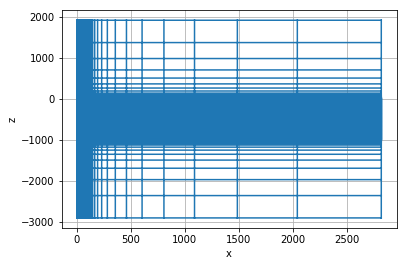

In [7]:
cylMeshGen.mesh.plotGrid()

In [8]:
src_theta = model.src_a[1] + hy[0]/2.

model.src_a[1] = src_theta
model.src_b[1] = src_theta

In [9]:
# # Plot the source location

# ax = plt.subplot(111, projection='polar')
# cylMeshGen.mesh.plotGrid(ax=ax, slice='z')
# ax.plot(model.src_a[1], model.src_a[0], 'ro')
# ax.plot(model.src_b[1], model.src_b[0], 'rs')
# ax.set_ylim([0., 3*model.casing_l])

In [10]:
# put the models in a dictionary for convienence 
target_sigma = [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2]
model_names = ["target_{:1.0e}".format(sig) for sig in target_sigma]

modelDict = {}

for name, sig in zip(model_names, target_sigma):
    tmp_model = model.copy()
    tmp_model.sigma_target = sig
    tmp_model.target_radius = np.r_[tmp_model.casing_b + tmp_model.casing_t, 25.]
    modelDict[name] = tmp_model
    
modelDict

{'target_1e+00': <casingSimulations.model.CasingInHalfspaceWithTarget at 0x1811bf7978>,
 'target_1e+01': <casingSimulations.model.CasingInHalfspaceWithTarget at 0x1811bf7d68>,
 'target_1e+02': <casingSimulations.model.CasingInHalfspaceWithTarget at 0x1811bf75f8>,
 'target_1e-01': <casingSimulations.model.CasingInHalfspaceWithTarget at 0x1811bf7fd0>,
 'target_1e-02': <casingSimulations.model.CasingInHalfspaceWithTarget at 0x1811bf7a20>,
 'target_1e-03': <casingSimulations.model.CasingInHalfspaceWithTarget at 0x1811bf2a58>,
 'target_1e-04': <casingSimulations.model.CasingInHalfspaceWithTarget at 0x1811bb4e80>}

In [11]:
# Assign physical properties on the mesh
physpropsDict = {
    key: casingSim.model.PhysicalProperties(cylMeshGen, modelDict[key]) 
    for key in model_names
}

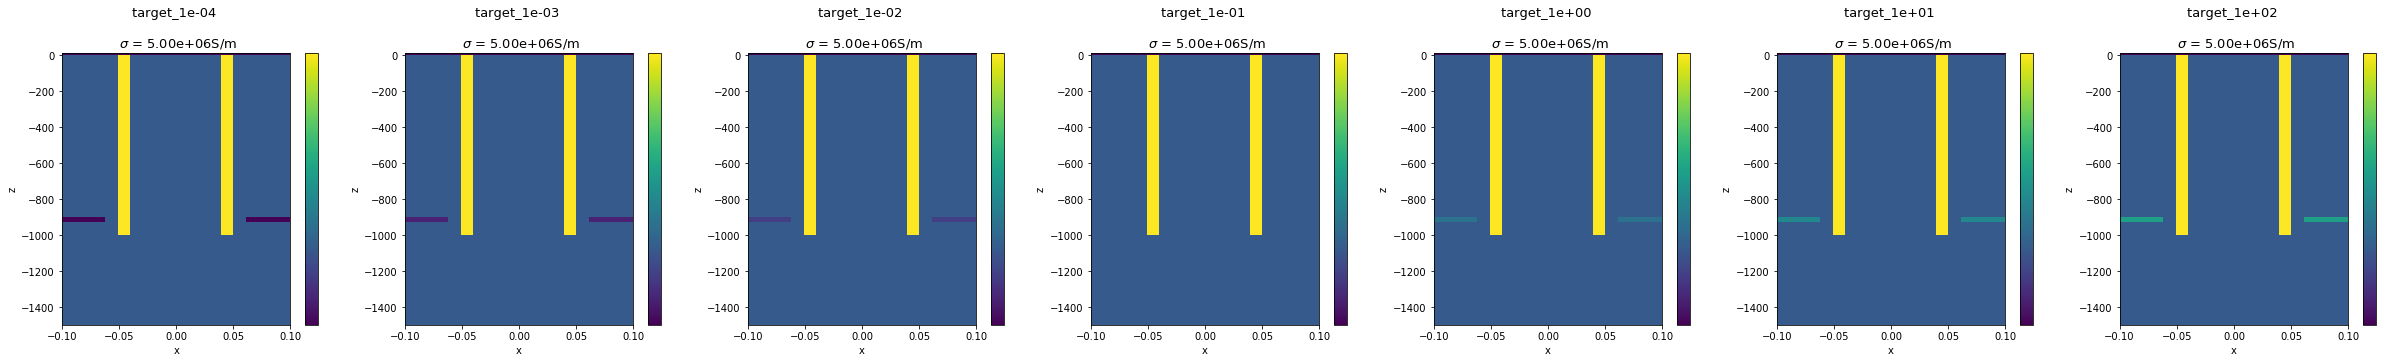

In [12]:
# Plot the models
xlim = 0.1*np.r_[-1, 1]  # x-limits in meters
zlim = np.r_[-1.5*model.casing_l, 10.]  # z-limits in meters. (z-positive up)

fig, ax = plt.subplots(1, len(model_names), figsize=(6*len(model_names), 5))
if len(model_names) == 1:
    ax=[ax]
    
for a, title in zip(ax, model_names):
    pp = physpropsDict[title]
    pp.plot_sigma(
        ax=a, 
        pcolorOpts={'norm':LogNorm()}  # plot on a log-scale
    )
    a.set_title('{} \n\n $\sigma$ = {:1.2e}S/m'.format(title, pp.modelParameters.sigma_casing), fontsize=13)
#     cylMeshGen.mesh.plotGrid(ax=a, slice='theta') # uncomment to plot the mesh on top of this
    a.set_xlim(xlim)
    a.set_ylim(zlim)

## Source locations

In [13]:
# Set up 4 sources, top casing, top & not coupled, downhole, downhole not coupled

src_a = np.vstack([
    [model.casing_r, src_theta, -1.25],
#     [model.casing_r + 0.1, src_theta, -1.25],
#     [model.casing_r, src_theta, -casing_l/2.],
#     [0., src_theta, -casing_l/2.],
    [model.casing_r, src_theta, -casing_l + 5.],
#     [0., src_theta, -casing_l + 5.],
#     [0., src_theta, -casing_l - 5.],
#     [model.casing_b+cylMeshGen.csx1*2, src_theta, -casing_l + 5.]
])

src_b = np.ones((src_a.shape[0],1)) * model.src_b

src_names = [
    "top casing",
#     "surface",
#     "center", 
#     "center, disconnected",
    "downhole",
#     "downhole, disconnected",
#     "below hole",
#     "outside hole"
]

## set up a DC simulation

In [14]:
simDict = {}
for title in model_names:
    simDict[title] = casingSim.run.SimulationDC(
        modelParameters=modelDict[title], directory=simDir, 
        meshGenerator=cylMeshGen, src_a=src_a, src_b=src_b
    )


Homogeneous Dirichlet is the natural BC for this CC discretization.
Homogeneous Dirichlet is the natural BC for this CC discretization.
Homogeneous Dirichlet is the natural BC for this CC discretization.
Homogeneous Dirichlet is the natural BC for this CC discretization.
Homogeneous Dirichlet is the natural BC for this CC discretization.
Homogeneous Dirichlet is the natural BC for this CC discretization.
Homogeneous Dirichlet is the natural BC for this CC discretization.


In [33]:
%%time
fieldsDict = {}
for title in model_names:
    print('--- Running {} ---'.format(title))
    fieldsDict[title] = simDict[title].run()
    print('\n')

--- Running target_1e-04 ---
Validating parameters...
      max x: 2819.9416722617116, min z: -2909.459170583198, max z: 1909.459170583198, nC: 37570
Saved DC_target/simulationParameters.json
Starting SimulationDC
Using <class 'pymatsolver.direct.Pardiso'> Solver
   ... Done. Elapsed time : 0.2826812267303467


--- Running target_1e-03 ---
Validating parameters...
      max x: 2819.9416722617116, min z: -2909.459170583198, max z: 1909.459170583198, nC: 37570
Saved DC_target/simulationParameters.json
Starting SimulationDC
Using <class 'pymatsolver.direct.Pardiso'> Solver
   ... Done. Elapsed time : 0.26314377784729004


--- Running target_1e-02 ---
Validating parameters...
      max x: 2819.9416722617116, min z: -2909.459170583198, max z: 1909.459170583198, nC: 37570
Saved DC_target/simulationParameters.json
Starting SimulationDC
Using <class 'pymatsolver.direct.Pardiso'> Solver
   ... Done. Elapsed time : 0.2628779411315918


--- Running target_1e-01 ---
Validating parameters...
      

## Plot Results

Here we plot the radial electric field along a line $90^{\circ}$ from the source. 

In [34]:
viewer = casingSim.FieldsViewer(
    sim_dict=simDict, fields_dict=fieldsDict, primary_key="target_{:1.0e}".format(sigma_back), model_keys=model_names
)

In [35]:
viewer.widget_cross_section()

interactive(children=(FloatText(value=0.1, description='max_r'), FloatText(value=-10.0, description='min_depth'), FloatText(value=1250.0, description='max_depth'), FloatText(value=0.0, description='clim_min'), FloatText(value=0.0, description='clim_max'), ToggleButtons(description='model_key', options=('target_1e-04', 'target_1e-03', 'target_1e-02', 'target_1e-01', 'target_1e+00', 'target_1e+01', 'target_1e+02', 'all'), value='target_1e-04'), ToggleButtons(description='view', options=('sigma', 'e', 'j', 'phi', 'charge', 'charge_density'), value='sigma'), ToggleButtons(description='prim_sec', options=('total', 'primary', 'secondary', 'percent'), value='total'), IntSlider(value=0, description='src_ind', max=1), Checkbox(value=False, description='show_mesh'), Checkbox(value=False, description='use_aspect'), Checkbox(value=True, description='casing_outline'), Output()), _dom_classes=('widget-interact',))

<function ipywidgets.widgets.interaction._InteractFactory.__call__.<locals>.<lambda>>

In [36]:
mesh = cylMeshGen.mesh

In [37]:
def excitation(key, src_ind=0, primary_key='target_1e-01'):
    primary_src = simDict[primary_key].survey.srcList[src_ind]
    
    ep = fieldsDict[primary_key][primary_src, 'e']
    ep = mesh.aveF2CCV * ep
    ex, ez = discretize.utils.mkvc(ep[:mesh.nC]), discretize.utils.mkvc(ep[mesh.nC:])
    
    sigma_sec = discretize.utils.mkvc(physpropsDict[key].sigma - physpropsDict[primary_key].sigma)
    
    jax, jaz = sigma_sec*ex, sigma_sec*ez
    jaxV, jazV = mesh.vol*jax, mesh.vol*jaz
    Jax, Jaz = np.sum(jaxV), np.sum(jazV)
    
    return np.sqrt(Jax**2 + Jaz**2)

In [38]:
for key in model_names:
    print("{:1.0e} & {:1.2f} {}".format(modelDict[key].sigma_target, excitation(key, src_ind=1), "\\\\"))
#     print(key, excitation(key))

1e-04 & 1.23 \\
1e-03 & 1.21 \\
1e-02 & 1.10 \\
1e-01 & 0.00 \\
1e+00 & 11.04 \\
1e+01 & 121.44 \\
1e+02 & 1225.48 \\


In [20]:
model_names

['target_1e-04',
 'target_1e-03',
 'target_1e-02',
 'target_1e-01',
 'target_1e+00',
 'target_1e+01',
 'target_1e+02']

In [23]:
from string import ascii_lowercase

In [24]:
from matplotlib import rcParams, ticker
rcParams['font.size'] = 12

In [ ]:
keys = ['target_{:1.0e}'.format(sig) for sig in [1e-3, 1e1]]
fig, ax = plt.subplots(len(keys), 4, figsize=(4*3.5,len(keys)*5))

fig.subplots_adjust(bottom=0.1)

src_ind = 0

max_r = 70
min_depth = 825
max_depth = 1025

zlim = np.r_[-max_depth, -min_depth]
xlim = max_r * np.r_[-1., 1.]
stream_opts = {"color":"k", "arrowsize":1.5}

for i, key in enumerate(keys):
    
    sigma_out = viewer.plot_cross_section(
        ax=ax[i][0], 
        clim=np.r_[1e-3, 1e7],
        xlim=xlim, 
        zlim=zlim,
        view='sigma', 
        theta_ind=0, 
        model_key=key, 
        show_cb=False, 
        use_aspect=True,
        casing_outline=True,
        stream_opts=stream_opts,
    )
    ax[i][0].text(
        max_r - 2, -max_depth+10, 
        "target: {:1.0e} S/m".format(float(key.split("_")[-1])), 
        color='w', fontsize=20, horizontalalignment="right"
    )
    
    charge_out = viewer.plot_cross_section(
        ax=ax[i][1], 
        clim=6e-16 * np.r_[-1, 1],
        xlim=xlim, 
        zlim=zlim,
        view='charge_density', 
        prim_sec='secondary',
        theta_ind=0, 
        model_key=key, 
        show_cb=False, 
        use_aspect=True,
        casing_outline=True,
        stream_opts=stream_opts,
    )
    
    
    currents_out = viewer.plot_cross_section(
        ax=ax[i][2], 
        clim= np.r_[1e-7, 1e-3],
        xlim=xlim, 
        zlim=zlim,
        view='j', 
        theta_ind=0, 
        model_key=key, 
        show_cb=False, 
        use_aspect=True,
        casing_outline=True,
        cb_extend='bottom',
        stream_opts=stream_opts,
    )
    
    efields_out = viewer.plot_cross_section(
        ax=ax[i][3], 
        clim= np.r_[1e-6, 1e-3],
        xlim=xlim, 
        zlim=zlim,
        view='e', 
        theta_ind=0, 
        model_key=key, 
        show_cb=False, 
        use_aspect=True,
        casing_outline=True,
        cb_extend='bottom',
        stream_opts=stream_opts,
    )
    
    if i == 0: 
        for j, a in enumerate(ax[i]):
            a.set_xticklabels(['']*len(a.get_xticklabels()))
            a.set_xlabel('')
            a.set_ylabel('z (m)')
            a.set_title('({})'.format(ascii_lowercase[j]))
            if j > 0:
                a.set_yticklabels(['']*len(a.get_xticklabels()))
                a.set_ylabel('')
    else:
        for j, a in enumerate(ax[i]):
            a.set_xlabel('x (m)')
            a.set_title('')
            a.set_ylabel('z (m)')
            if j > 0:
                a.set_yticklabels(['']*len(a.get_xticklabels()))
                a.set_ylabel('')
    
#     for a in ax[i]:
#         plt.plot()


# cbar_ax = fig.add_axes([0.25, -0.01, 0.11, 0.01])
# cb_charge = fig.colorbar(charge_out[0], ax=cbar_ax, orientation='horizontal')
        
plt.tight_layout()

for i, out, label in zip(
    np.arange(4), 
    [sigma_out, charge_out, currents_out, efields_out],
    ['conductivity (S/m)', 'secondary \n charge density (C/m$^3$)', 'current density (A/m$^2$)', 'electric field (V/m)'],
#     [None, None, 'min', 'min']
):
    x = ax[1][i].figbox.corners()[0, 0]
    cbar_ax = fig.add_axes([x+0.025, -0.01, 0.175, 0.015])
    cb = fig.colorbar(
        out[0], cbar_ax, orientation="horizontal"
    )
    cb.set_label(label)
    cb.set_ticks([cb.vmin, cb.vmax])
    cb.update_ticks()

plt.show() 

fig.savefig('target_physics', bbox_inches="tight", dpi=350)

In [26]:
key = "target_1e+01"
baseline_key = "target_1e-01"

for key in model_names: 
    m = modelDict[key]
    src = simDict[key].survey.srcList[0]
    charge_density = fieldsDict[key][src, "charge_density"]

    secondary_charge_density = charge_density - fieldsDict[baseline_key][simDict[baseline_key].survey.srcList[0], "charge_density"]

    print(
         "{}   min: {:1.1e}, max: {:1.1e}, min outside casing: {:1.1e}, max outside casing: {:1.1e}".format(
            key,
            secondary_charge_density.min(), secondary_charge_density.max(), 
            secondary_charge_density[~m.ind_casing(mesh)].min(), secondary_charge_density[~m.ind_casing(mesh)].max(), 
        )
    )

target_1e-04   min: -3.2e-11, max: 2.3e-11, min outside casing: -2.9e-11, max outside casing: 2.3e-11
target_1e-03   min: -3.2e-11, max: 2.3e-11, min outside casing: -2.9e-11, max outside casing: 2.3e-11
target_1e-02   min: -2.8e-11, max: 2.0e-11, min outside casing: -2.6e-11, max outside casing: 2.0e-11
target_1e-01   min: 0.0e+00, max: 0.0e+00, min outside casing: 0.0e+00, max outside casing: 0.0e+00
target_1e+00   min: -8.1e-11, max: 1.1e-10, min outside casing: -8.1e-11, max outside casing: 1.0e-10
target_1e+01   min: -1.4e-10, max: 2.0e-10, min outside casing: -1.4e-10, max outside casing: 1.8e-10
target_1e+02   min: -1.5e-10, max: 2.2e-10, min outside casing: -1.5e-10, max outside casing: 2.0e-10


In [75]:
6e-16/9e-17

6.666666666666667

In [29]:
# plot currents in casing

epsilon = 1e-16
baseline_key = 'target_{:1.0e}'.format(sigma_back)

def plot_casing_currents_multisrc(model=baseline_key):

    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    ax = discretize.utils.mkvc(ax)

    f = fieldsDict[model]
    mod = modelDict[model]
        
    for i, src in enumerate(simDict[model].survey.srcList):
        
        currents = casingSim.physics.casing_currents(
            f[src, 'j'], cylMeshGen.mesh, modelDict[baseline_key]
        )
        
        ax[0].plot(currents['z'][0], -currents['z'][1], label=src_names[i], color="C{}".format(i))
        ax[1].plot(currents['z'][0], np.absolute(currents['z'][1]), label=src_names[i], color="C{}".format(i))
        
            
    
    [a.set_xlim([0., -casing_l]) for a in ax]
    [a.legend() for a in ax]
    [a.set_xlabel('z (m)') for a in ax]

    ax[0].set_ylabel('Downward-going Current (A)')
    ax[1].set_ylabel('Vertical Current Amplitude (A)')
    
    plt.tight_layout()
    plt.show()

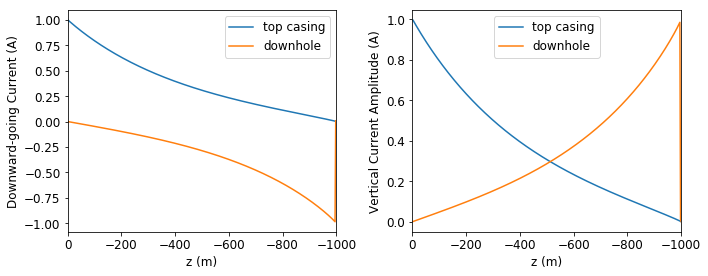

In [30]:
plot_casing_currents_multisrc()

In [39]:
# plot currents in casing

epsilon = 1e-16
baseline_key = 'target_{:1.0e}'.format(sigma_back)

def plot_casing_currents(src_ind=0):

    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    ax = discretize.utils.mkvc(ax)

    
        
    for i, key in enumerate(model_names):
        
        src = simDict[key].survey.srcList[src_ind]
        f = fieldsDict[key]
        mod = modelDict[key]
        
        currents = casingSim.physics.casing_currents(
            f[src, 'j'], cylMeshGen.mesh, modelDict[baseline_key]
        )
        
        ax[0].plot(currents['z'][0], -currents['z'][1], label=key, color="C{}".format(i))
        ax[1].plot(currents['z'][0], np.absolute(currents['z'][1]), label=key, color="C{}".format(i))
        
            
    
    [a.set_xlim([0., -casing_l]) for a in ax]
    [a.legend() for a in ax]
    [a.set_xlabel('z (m)') for a in ax]

    ax[0].set_ylabel('Downward-going Current (A)')
    ax[1].set_ylabel('Vertical Current Amplitude (A)')
    
    plt.tight_layout()
    plt.show()

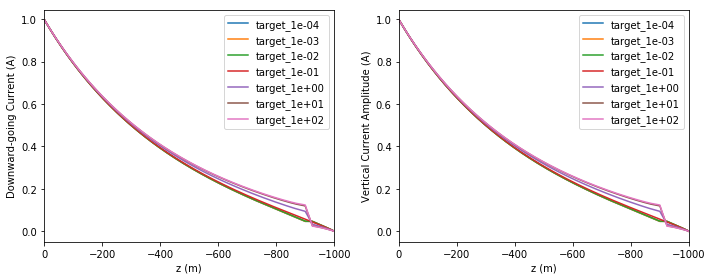

In [40]:
plot_casing_currents()

In [31]:
def current_flux(mesh, j, radius=1):
    Fx_inds = np.absolute(mesh.gridFx[:,0] - radius) == np.min(np.absolute(mesh.vectorNx - radius))
#     Fz_inds = np.absolute(mesh.gridFz[:,0] - radius) == np.min(np.absolute(mesh.vectorCCx - radius))
    Fz_inds = (mesh.gridFz[:, 0] > model.casing_b) & (mesh.gridFz[:, 0] <= radius)

    jA = utils.sdiag(mesh.area) * j
#     jA = j
    jA_surface_x = jA[
        np.hstack([Fx_inds, np.zeros(mesh.nFy, dtype=bool), np.zeros(mesh.nFz, dtype=bool)])
    ].reshape(mesh.vnFx[1], mesh.vnFx[2], order='F')
    
    jA_surface_z = jA[
        np.hstack([np.zeros(mesh.nFx, dtype=bool), np.zeros(mesh.nFy, dtype=bool), Fz_inds])
    ].reshape(
        int(np.sum((mesh.vectorCCx > model.casing_b) & (mesh.vectorCCx <= radius))),
        mesh.vnFz[1], mesh.vnFz[2], order='F'
    )

    ix = jA_surface_x.sum(0)
    iz = jA_surface_z.sum(0).sum(0)
    
    return ix, iz

In [32]:
# # plot currents in casing

# epsilon = 1e-16

# def plot_formation_currents(src_ind=0, radius=1, ymax=None):
   
#     src_baseline = simDict['baseline'].survey.srcList[src_ind]

#     fig, ax = plt.subplots(1, 2, figsize=(10, 4), dpi=400)
#     ax = discretize.utils.mkvc(ax)

#     baseline_src = simDict['baseline'].survey.srcList[src_ind]
#     ix_baseline = horizontal_current_flux(
#         cylMeshGen.mesh, fieldsDict['baseline'][baseline_src, 'j'], radius
#     )
    
#     for i, key in enumerate(model_names):
#         f = fieldsDict[key]
#         src = simDict[key].survey.srcList[src_ind]
        
#         ix = horizontal_current_flux(
#             cylMeshGen.mesh, fieldsDict[key][src, 'j'], radius
#         )
        
#         ax[0].plot(cylMeshGen.mesh.vectorCCz, ix, label=key, color="C{}".format(i))

#         if key != 'baseline':
        
#             ax[1].plot(
#                 cylMeshGen.mesh.vectorCCz, 
#                 np.absolute(ix-ix_baseline)/(np.absolute(ix_baseline)+epsilon)*100,
#                 label=key, color="C{}".format(i)
#             )
    
#     [a.set_xlim([0., -1.25*casing_l]) for a in ax]
#     [a.legend() for a in ax]
#     [a.set_xlabel('z (m)') for a in ax]
    
#     if not ymax is not None or ymax !=0:
#         ylim = [0, ymax]
#         ax[0].set_ylim(ylim)

#     ax[0].set_ylabel('Horizontal currents (A)')
#     ax[1].set_ylabel('Percent difference from baseline')
    
#     ax[0].set_title(src_names[src_ind] + ' source \n\n Horizontal Current in Formation, r={}'.format(radius))
#     ax[1].set_title('Difference from baseline (%)')
    
    
#     plt.tight_layout()
#     plt.show()

In [33]:
# ipywidgets.interact(
#     plot_formation_currents,
#     src_ind=ipywidgets.IntSlider(min=0, max=len(src_names)-1, value=0), 
#     radius=ipywidgets.FloatText(value=10),
#     ymax=ipywidgets.FloatText(value=0)
# )

In [34]:
src_names

['top casing', 'downhole']

In [35]:
from matplotlib import rcParams
rcParams['font.size'] = 12

KeyError: 'baseline'

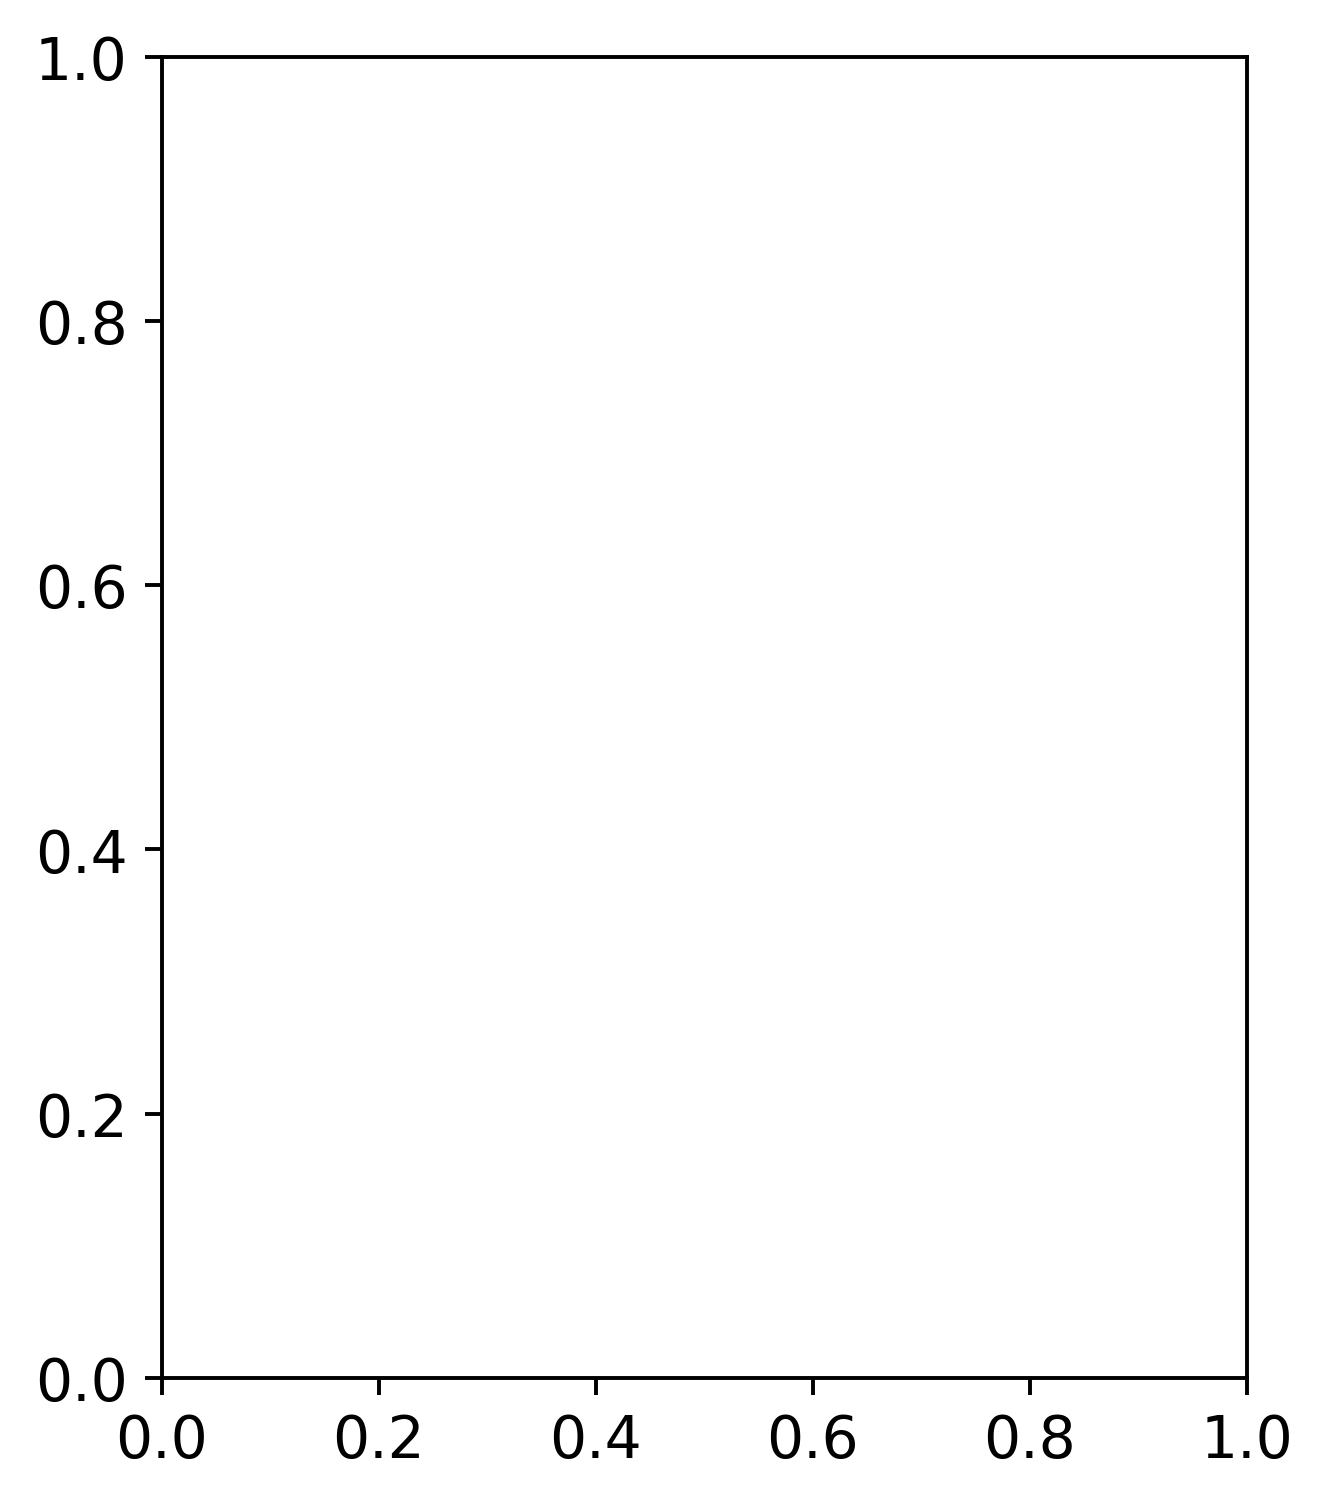

In [36]:
# Plot the source location

xlim = 0.2 * np.r_[-1, 1]
# symbols = ['v', 'v', '>', '>', 'v', 'C3s']

fig, ax = plt.subplots(1, 1, figsize=(4, 5), dpi=350)
# cylMeshGen.mesh.plotGrid(ax=ax, slice='theta')
out = physpropsDict['baseline'].plot_sigma(
    ax=ax, 
    pcolorOpts={'norm':LogNorm(), 'cmap': 'Greys'},  # plot on a log-scale
    clim = np.r_[sigma_back, 1e20], 
    show_cb = False
)

ax.plot(xlim, np.zeros(2), color='0.2')

for i in range(src_a.shape[0]):
    if src_a[i, 2] < -10:
        label = "{}: {:1.0f}m depth".format(
            src_names[i], -src_a[i, 2]
        )
    else:
        label = "{}: {:1.2f}m depth".format(
            src_names[i], -src_a[i, 2]
        )
    ax.plot(src_a[i, 0], src_a[i, 2], 'o', ms=8, color="C{}".format(i), label=label)
    ax.plot(src_b[i, 0], src_b[i, 2], 'o', ms=8, color="C{}".format(i))
    
ax.legend(loc = 9, bbox_to_anchor=[0.5, 1.4])
ax.set_xlim(xlim) #src_b[:, 0].max()])
ax.set_ylim([-1.1 * modelDict[model_names[0]].casing_l, 10])
ax.set_title('')
ax.set_xlabel('x (m)')
ax.set_ylabel('y (m)')

fig.savefig('electrode_location', bbox_inches="tight")


In [ ]:
# # plot currents in casing

# epsilon = 1e-16

# def plot_formation_currents_multisrc(radius=100, model='baseline'):
   
#     fig, ax = plt.subplots(3, 1, figsize=(7, 10.5))
#     ax = discretize.utils.mkvc(ax)
    
#     f = fieldsDict[model]
    
#     for i, src in enumerate(simDict[model].survey.srcList):
        
#         ix, iz = current_flux(
#             cylMeshGen.mesh, fieldsDict[model][src, 'j'], radius
#         )
        
# #         iz = vertical_current_flux(
# #             cylMeshGen.mesh, fieldsDict[model][src, 'j'], radius
# #         )
        
# #         ax[0].plot(cylMeshGen.mesh.vectorCCz, ix, label=src_names[i], color="C{}".format(i))
#         ax[0].semilogy(cylMeshGen.mesh.vectorCCz, np.abs(ix), label=src_names[i], color="C{}".format(i))
#         ax[1].semilogy(cylMeshGen.mesh.vectorNz, np.abs(iz), label=src_names[i], color="C{}".format(i))

    
#     for a in ax: 
#         a.set_xlim([0., -1.25*casing_l])
#         a.legend() 
#         a.set_xlabel('z (m)') 
#         a.set_ylim([6e-5, 1])
# #         a.set_ylim([1e-7, 6e-4])


#     ax[0].set_ylabel('Horizontal current (A)') 
#     ax[1].set_ylabel('Vertical current (A)')

#     ax[0].set_title('Current density in formation, r={}'.format(radius))
# #     ax[1].set_title('')
    
# #     ax[0].set_ylim([1e-4, 2e-1])
# #     ax[0].set_ylim([1e-7, 6e-4])
    
#     plt.tight_layout()
#     plt.show()
    
#     return ax

In [ ]:
mesh = cylMeshGen.mesh

In [ ]:
model = 'baseline'

src = simDict[model].survey.srcList[0]
j = mesh.aveF2CCV * fieldsDict[model][src, 'j']
print(j.shape)

In [ ]:
mesh.nC*2

In [ ]:
# plot_formation_currents_multisrc(radius=50)

In [ ]:
mesh = cylMeshGen.mesh
from string import ascii_lowercase

In [ ]:
# plot currents in casing

epsilon = 1e-16

def plot_current_density_multisrc(ax=None, radius=50, model='baseline', theta_ind =0):
   
    if ax is None: 
        fig, ax = plt.subplots(3, 1, figsize=(7, 10.5), dpi=350)
        ax = discretize.utils.mkvc(ax)
    
    f = fieldsDict[model]
    
    for i, src in enumerate(simDict[model].survey.srcList):
        
        x_ind = mesh.vectorCCx - radius == np.min(np.absolute(mesh.vectorCCx - radius))
        
        print(mesh.vectorCCx[x_ind])
        
        j = mesh.aveF2CCV * fieldsDict[model][src, 'j']
        j = j.reshape((mesh.nC, int(len(j)/mesh.nC)), order='F')
        jx = discretize.utils.mkvc(j[:,0].reshape(mesh.vnC, order='F')[x_ind, theta_ind, :])
        jz = discretize.utils.mkvc(j[:,1].reshape(mesh.vnC, order='F')[x_ind, theta_ind, :])
        jt = np.sqrt(jx**2 + jz**2)
        
#     ix = jA_surface_x.sum(0)
#     iz = jA_surface_z.sum(0).sum(0)
    
#         ix, iz = current_flux(
#             cylMeshGen.mesh, fieldsDict[model][src, 'j'], radius
#         )
        
#         iz = vertical_current_flux(
#             cylMeshGen.mesh, fieldsDict[model][src, 'j'], radius
#         )
        
#         ax[0].plot(cylMeshGen.mesh.vectorCCz, ix, label=src_names[i], color="C{}".format(i))
        ax[0].semilogy(-cylMeshGen.mesh.vectorCCz, np.abs(jx), label=src_names[i], color="C{}".format(i))
        ax[1].semilogy(-cylMeshGen.mesh.vectorCCz, np.abs(jz), label=src_names[i], color="C{}".format(i))
        ax[2].semilogy(-cylMeshGen.mesh.vectorCCz, jt, label=src_names[i], color="C{}".format(i))

    
    for i, a in enumerate(ax): 
        a.set_xlim([0., 1.5*casing_l])
#         a.legend() 
        a.set_xlabel('depth (m)') 
        a.set_title('({})'.format(ascii_lowercase[i]))
        a.grid('both', linestyle='-', linewidth=0.4, color=[0.8, 0.8, 0.8])

#         a.set_ylim([6e-5, 1])
#         a.set_ylim([1e-7, 6e-4])

    ax[0].legend()


    ax[0].set_ylabel('$j_r$ (A/m)') 
    ax[1].set_ylabel('$j_z$ (A/m)')
    ax[2].set_ylabel('$|j|$ (A/m)')

#     ax[0].set_title('Current density in formation, r={}'.format(radius))
#     ax[1].set_title('')
    
#     ax[0].set_ylim([1e-4, 2e-1])
#     ax[0].set_ylim([1e-7, 6e-4])
      
    return ax

In [ ]:
fig, ax = plt.subplots(3, 1, figsize=(7, 10.5), dpi=350)

ax = plot_current_density_multisrc(ax=ax, radius=50)
[a.set_ylim([6e-8, 6e-5]) for a in ax]
# [a.set_ylim([1e-6, 1e-5]) for a in ax]

# ax[1].set_ylim([1e-9, 1e-1])
plt.tight_layout()
plt.show()

# fig.savefig('electrode_location_currents', dpi=350)

## Charges

How do the charges change with different casing models?

### Widget for viewing charges

There are 3 panels, the true (left), if we were to replace the well with solid steel (center) and if we choose sigma to preserve the integrated conductance (right). For reference, I have plotted the true casing cross section.

The widgets available to you are
- **theta_ind**: [0, ntheta slices] Which azimuth should we slice through
- **clim_max**: max value on the colorbar so you can saturate it
- **max_depth**: max z-limit for the plot
- **top**: top of the plot (z)

observations:
- (sanity checks): in all charges at interface between casing and formation. All positive charges (positive electrode connected to casing
- charge distribution more uniform along length of casing for solid steel (also makes sense: better conductor)

In [ ]:
viewer = casingSim.FieldsViewer(
    sim_dict=simDict, fields_dict=fieldsDict, model_keys=model_names
)

In [ ]:
viewer.widget_cross_section()

### Total charge on the casing

- integrate the charge on the casing. 

In [ ]:
casing_charge = {}
for title in model_names:
    casing_charge[title] = (
        utils.mkvc(simDict[title].fields()[:, 'charge'])
    )[modelDict[title].ind_casing(cylMeshGen.mesh)].sum()
    print('{:8s}: {:1.8e}'.format(title, casing_charge[title]))